In [11]:
# Append system path
import sys, os
sys.path.append(os.path.abspath('../inference'))

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Import Model and NMS classes
from object_detection import Model
from nms import NMS

# Initialize models for both YOLO versions
model_1 = Model(weights_file="../storage/yolo_model_1/yolov4-tiny-logistics_size_416_1.weights", 
                config_file="../storage/yolo_model_1/yolov4-tiny-logistics_size_416_1.cfg", 
                names_file="../storage/yolo_model_1/logistics.names")

model_2 = Model(weights_file="../storage/yolo_model_2/yolov4-tiny-logistics_size_416_2.weights", 
                config_file="../storage/yolo_model_2/yolov4-tiny-logistics_size_416_2.cfg", 
                names_file="../storage/yolo_model_2/logistics.names")

In [48]:
# Path to the test images and labels
image_dir = "../storage/logistics/"
image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')]
label_paths = [f.replace('.jpg', '.txt') for f in image_paths]

## Util Functions

In [13]:
import numpy as np

# IoU calculation function
def calculate_iou(boxA, boxB):
    """
    Calculate IoU between two bounding boxes in (x_min, y_min, width, height) format.

    :param boxA: First bounding box [x_min, y_min, width, height].
    :param boxB: Second bounding box [x_min, y_min, width, height].
    :return: Intersection over Union (IoU) score.
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])

    # Compute the area of intersection
    inter_width = max(0, xB - xA)
    inter_height = max(0, yB - yA)
    interArea = inter_width * inter_height

    # Compute the area of both bounding boxes
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]

    # Compute the Intersection over Union (IoU)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

# Function to convert YOLO format to (x_min, y_min, width, height)
def convert_yolo_to_bbox(yolo_box, image_width, image_height):
    """
    Convert YOLO format (center_x, center_y, width, height) to (x_min, y_min, width, height).
    
    :param yolo_box: YOLO format bounding box [center_x, center_y, width, height] (values are relative to image size).
    :param image_width: Original image width.
    :param image_height: Original image height.
    :return: Bounding box in (x_min, y_min, width, height) format.
    """
    center_x, center_y, bbox_w, bbox_h = yolo_box
    center_x *= image_width
    center_y *= image_height
    bbox_w *= image_width
    bbox_h *= image_height

    x_min = int(center_x - bbox_w / 2)
    y_min = int(center_y - bbox_h / 2)
    return [x_min, y_min, int(bbox_w), int(bbox_h)]

# Function to read YOLO-format ground truth labels
def read_yolo_labels(label_file):
    labels = []
    with open(label_file, 'r') as f:
        for line in f:
            class_id, x_center, y_center, width, height = map(float, line.strip().split())
            labels.append((int(class_id), x_center, y_center, width, height))
    return labels

# Function to calculate IoU and precision-recall for each image
def calculate_precision_recall(image_path, label_path, model, nms_instance, score_threshold=0.5, iou_threshold=0.5):
    """
    Calculate precision and recall by comparing predictions with ground truth boxes.
    
    :param image_path: Path to the image file.
    :param label_path: Path to the YOLO-format label file.
    :param model: The object detection model to make predictions.
    :param nms_instance: The NMS instance to filter predictions.
    :param score_threshold: Score threshold for filtering predictions.
    :param iou_threshold: IoU threshold to consider a prediction valid.
    :return: Precision, recall, and IoU scores.
    """
    # Read the image
    image = cv.imread(image_path)
    image_height, image_width = image.shape[:2]

    # Read the ground truth labels
    ground_truth = read_yolo_labels(label_path)

    # Convert ground truth boxes to (x_min, y_min, width, height)
    ground_truth_bboxes = [convert_yolo_to_bbox([x, y, w, h], image_width, image_height) for _, x, y, w, h in ground_truth]
    ground_truth_class_ids = [gt_class for gt_class, _, _, _, _ in ground_truth]  # Ground truth class IDs

    # Run model prediction and post-processing
    outputs, _ = model.predict(image)
    bboxes, class_ids, scores = model.post_process(outputs, (image_height, image_width), score_threshold=score_threshold)

    # Apply NMS
    filtered_bboxes, filtered_class_ids, filtered_scores = nms_instance.filter(bboxes, class_ids, scores)

    # True Positives, False Positives, False Negatives
    true_positives = 0
    false_positives = 0
    false_negatives = len(ground_truth_bboxes)  

    # List to store IoU scores for each predicted box
    iou_scores = []

    # Track ground truth boxes that have been matched
    matched_gt_boxes = [False] * len(ground_truth_bboxes)

    # Evaluate predictions
    for pred_bbox, pred_class_id in zip(filtered_bboxes, filtered_class_ids):
        best_iou = 0
        best_gt_idx = -1

        # Compare each prediction with every ground truth box
        for idx, gt_bbox in enumerate(ground_truth_bboxes):
            gt_class_id = ground_truth_class_ids[idx]
            iou = calculate_iou(pred_bbox, gt_bbox)

            # Track the highest IoU match for this prediction and check if the class IDs match
            if iou > best_iou and pred_class_id == gt_class_id:
                best_iou = iou
                best_gt_idx = idx

        iou_scores.append(best_iou)

        # If the best IoU is greater than the threshold, it's a valid detection (true positive)
        if best_iou >= iou_threshold and not matched_gt_boxes[best_gt_idx]:
            true_positives += 1
            matched_gt_boxes[best_gt_idx] = True  # Mark the ground truth box as matched
        else:
            # If IoU is low or no match found, it's a false positive
            false_positives += 1

    # Calculate the remaining false negatives (ground truth boxes that were never matched)
    false_negatives -= sum(matched_gt_boxes)

    # Calculate precision and recall
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    return precision, recall, iou_scores

def display_image_with_bboxes(image_path, label_path, model, nms_instance, score_threshold=0.5, iou_threshold=0.5):
    """
    Display an image with both ground truth and predicted bounding boxes.
    
    :param image_path: Path to the image file.
    :param label_path: Path to the YOLO-format label file.
    :param model: The object detection model to make predictions.
    :param nms_instance: The NMS instance to filter predictions.
    :param score_threshold: Score threshold for filtering predictions.
    :param iou_threshold: IoU threshold to consider a detection valid.
    """
    # Load the image
    image = cv.imread(image_path)
    image_height, image_width = image.shape[:2]

    # Read the ground truth labels
    ground_truth = read_yolo_labels(label_path)

    # Convert ground truth boxes to (x_min, y_min, width, height)
    ground_truth_bboxes = [convert_yolo_to_bbox([x, y, w, h], image_width, image_height) for _, x, y, w, h in ground_truth]
    ground_truth_class_ids = [gt_class for gt_class, _, _, _, _ in ground_truth]

    # Run model prediction and post-processing
    outputs, _ = model.predict(image)
    bboxes, class_ids, scores = model.post_process(outputs, (image_height, image_width), score_threshold=score_threshold)

    # Apply NMS
    filtered_bboxes, filtered_class_ids, filtered_scores = nms_instance.filter(bboxes, class_ids, scores)

    # Draw ground truth bounding boxes (in red)
    for gt_bbox in ground_truth_bboxes:
        x, y, w, h = gt_bbox
        cv.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)  # Red boxes for ground truth

    # Draw predicted bounding boxes (in green)
    for i, pred_bbox in enumerate(filtered_bboxes):
        x, y, w, h = pred_bbox
        label = f"{model.classes[filtered_class_ids[i]]}: {filtered_scores[i]:.2f}"
        cv.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green boxes for predictions
        cv.putText(image, label, (x, y - 10), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Convert the image from BGR to RGB for plotting
    image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    # Display the image with bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.title("Predicted (Green) and Ground Truth (Red) Bounding Boxes")
    plt.axis("off")
    plt.show()

## Initial EDA

Here we can select an image and calculate the IoU, Precision, and Recall scores. We can also view the image with grouth truth and prediction boxes.

In [49]:
# Select an image and set thresholds
image_num = 100
score_threshold = 0.5
iou_threshold = 0.5

image_path = image_paths[image_num]  
label_path = label_paths[image_num] 

print(f"Ground Truth Labels:\n{read_yolo_labels(label_path)}")

precision_1, recall_1, iou_scores_1 = calculate_precision_recall(image_path, label_path, model_1, NMS(), score_threshold=score_threshold, iou_threshold=iou_threshold)
precision_2, recall_2, iou_scores_2 = calculate_precision_recall(image_path, label_path, model_2, NMS(), score_threshold=score_threshold, iou_threshold=iou_threshold)

print("Model 1 Precision:", precision_1)
print("Model 1 Recall:", recall_1)
print("Model 1 IoU Scores:", iou_scores_1)

print("Model 2 Precision:", precision_2)
print("Model 2 Recall:", recall_2)
print("Model 2 IoU Scores:", iou_scores_2)


Ground Truth Labels:
[(10, 0.4671875, 0.47578125, 0.05625, 0.1984375), (10, 0.50859375, 0.31484375, 0.0515625, 0.2265625), (7, 0.45625, 0.3875, 0.021875, 0.021875), (10, 0.47734375, 0.240625, 0.0546875, 0.14375), (7, 0.52734375, 0.25078125, 0.0171875, 0.0265625)]
Model 1 Precision: 0
Model 1 Recall: 0.0
Model 1 IoU Scores: []
Model 2 Precision: 0.5
Model 2 Recall: 0.2
Model 2 IoU Scores: [0.5052631578947369, 0]


Model 1 Image



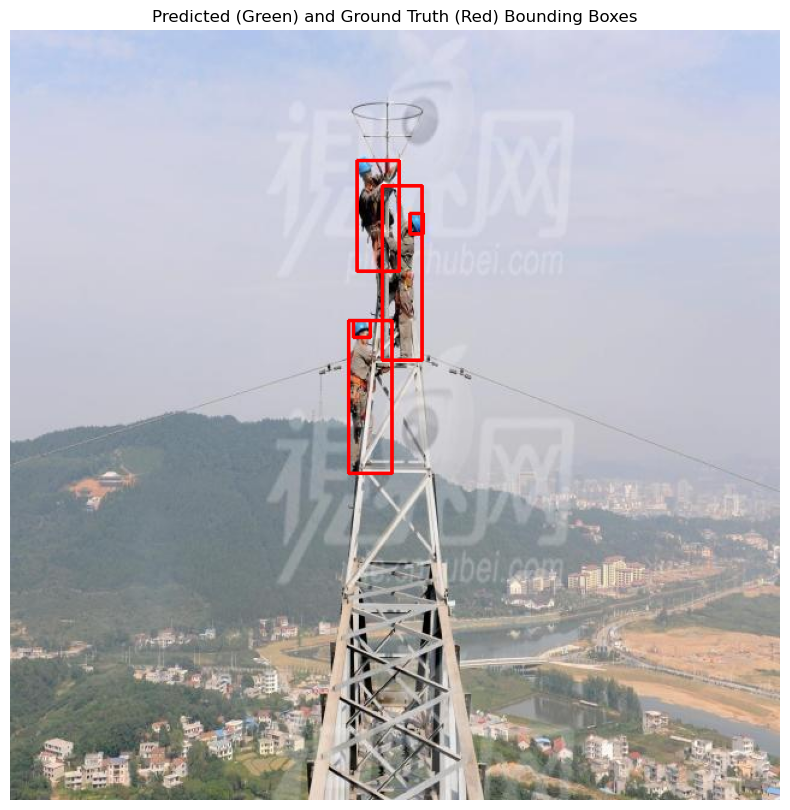

Model 2 Image



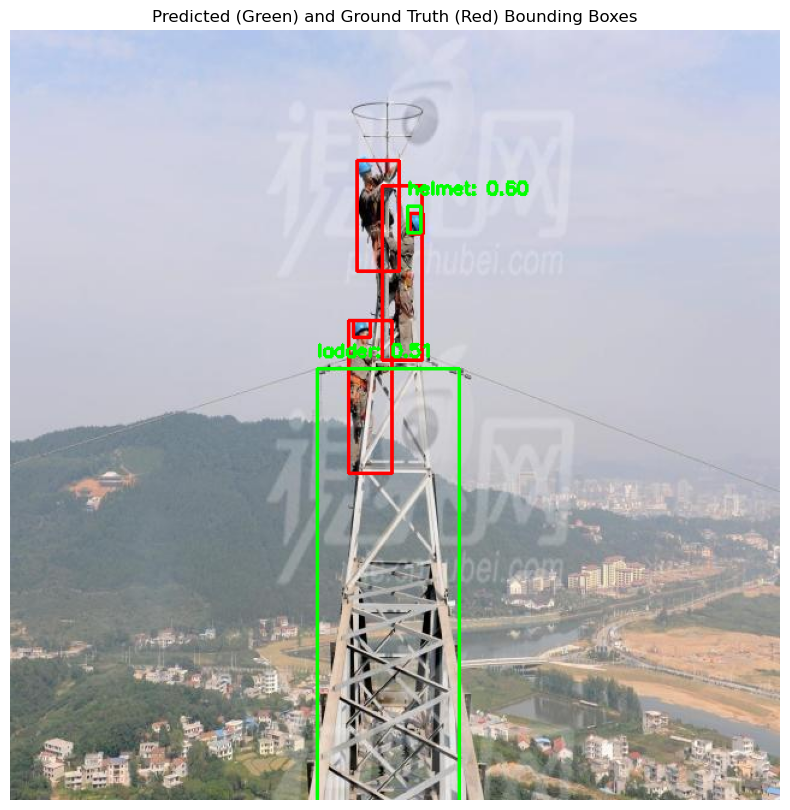

In [50]:
# View Images
print("Model 1 Image\n")
display_image_with_bboxes(image_path, label_path, model_1, NMS(), score_threshold=0.5)
print("Model 2 Image\n")
display_image_with_bboxes(image_path, label_path, model_2, NMS(), score_threshold=0.5)

## Evaluating Model Mean Average Precision

In [44]:
def get_avg_precision_recall(image_paths, label_paths, model, nms_instance, score_threshold=0.5, iou_threshold=0.5):
    precisions = []
    recalls = []
    for image_path, label_path in zip(image_paths, label_paths):
        precision, recall, _ = calculate_precision_recall(image_path, label_path, model, nms_instance, score_threshold=score_threshold, iou_threshold=iou_threshold)
        precisions.append(precision)
        recalls.append(recall)

    return precisions, recalls

In [45]:
score_thresholds = [0.2, 0.4, 0.6, 0.8]
iou_threshold = 0.5  # Keeping IoU threshold constant

for score_threshold in score_thresholds:
    # Get average precision and recall for the current score threshold
    model_1_precisions, model_1_recalls = get_avg_precision_recall(
        image_paths, 
        label_paths, 
        model_1, 
        NMS(), 
        score_threshold=score_threshold, 
        iou_threshold=iou_threshold
    )
    
    # Print the results for the current threshold
    print(f"Score Threshold: {score_threshold}")
    print(f"Model 1 Average Precision: {np.mean(model_1_precisions)}")
    print(f"Model 1 Average Recall: {np.mean(model_1_recalls)}")
    print(f"IoU Threshold: {iou_threshold}")
    print("-" * 50)  # Divider between threshold results


Score Threshold: 0.2
Model 1 Average Precision: 0.7032690909259207
Model 1 Average Recall: 0.6930164608277891
IoU Threshold: 0.5
--------------------------------------------------
Score Threshold: 0.4
Model 1 Average Precision: 0.6737297756136731
Model 1 Average Recall: 0.5889728958394606
IoU Threshold: 0.5
--------------------------------------------------
Score Threshold: 0.6
Model 1 Average Precision: 0.5797044521370327
Model 1 Average Recall: 0.46500407905470226
IoU Threshold: 0.5
--------------------------------------------------
Score Threshold: 0.8
Model 1 Average Precision: 0.4170860455174381
Model 1 Average Recall: 0.31115056481441955
IoU Threshold: 0.5
--------------------------------------------------


In [46]:
print("Results for Model 2")
for score_threshold in score_thresholds:
    # Get average precision and recall for the current score threshold
    model_2_precisions, model_2_recalls = get_avg_precision_recall(
        image_paths, 
        label_paths, 
        model_2, 
        NMS(), 
        score_threshold=score_threshold, 
        iou_threshold=iou_threshold
    )
    
    # Print the results for the current threshold
    print(f"Score Threshold: {score_threshold}")
    print(f"Model 2 Average Precision: {np.mean(model_2_precisions)}")
    print(f"Model 2 Average Recall: {np.mean(model_2_recalls)}")
    print(f"IoU Threshold: {iou_threshold}")
    print("-" * 50)  # Divider between threshold results



Results for Model 2
Score Threshold: 0.2
Model 2 Average Precision: 0.7134452187862464
Model 2 Average Recall: 0.7281316263772237
IoU Threshold: 0.5
--------------------------------------------------
Score Threshold: 0.4
Model 2 Average Precision: 0.7138471659194299
Model 2 Average Recall: 0.6448484852437717
IoU Threshold: 0.5
--------------------------------------------------
Score Threshold: 0.6
Model 2 Average Precision: 0.6573050841183947
Model 2 Average Recall: 0.5496962186146208
IoU Threshold: 0.5
--------------------------------------------------
Score Threshold: 0.8
Model 2 Average Precision: 0.5271233566125325
Model 2 Average Recall: 0.40797784289840944
IoU Threshold: 0.5
--------------------------------------------------


## Calculate Per Class


In [32]:
def calculate_precision_recall_per_class(image_paths, label_paths, model, nms_instance, score_threshold=0.5, iou_threshold=0.5):
    """
    Calculate precision and recall for each class by comparing predictions with ground truth boxes.
    
    :param image_paths: List of paths to images.
    :param label_paths: List of paths to corresponding YOLO label files.
    :param model: The object detection model to make predictions.
    :param nms_instance: The NMS instance to filter predictions.
    :param score_threshold: Score threshold for filtering predictions.
    :param iou_threshold: IoU threshold to consider a prediction valid.
    :return: Dictionary of average precision and recall per class.
    """
    class_metrics = {}

    for image_path, label_path in zip(image_paths, label_paths):
        # Read image and ground truth labels
        image = cv.imread(image_path)
        image_height, image_width = image.shape[:2]
        ground_truth = read_yolo_labels(label_path)

        # Convert ground truth boxes to (x_min, y_min, width, height)
        gt_bboxes = [convert_yolo_to_bbox([x, y, w, h], image_width, image_height) for _, x, y, w, h in ground_truth]
        gt_class_ids = [gt_class for gt_class, _, _, _, _ in ground_truth]

        # Run model prediction and post-processing
        outputs, _ = model.predict(image)
        bboxes, class_ids, scores = model.post_process(outputs, (image_height, image_width), score_threshold)

        # Apply NMS
        filtered_bboxes, filtered_class_ids, filtered_scores = nms_instance.filter(bboxes, class_ids, scores)

        # Track precision and recall per class
        for gt_class_id in set(gt_class_ids):
            if gt_class_id not in class_metrics:
                class_metrics[gt_class_id] = {"tp": 0, "fp": 0, "fn": 0}

        matched_gt_boxes = [False] * len(gt_bboxes)

        # Evaluate predictions
        for pred_bbox, pred_class_id in zip(filtered_bboxes, filtered_class_ids):
            best_iou = 0
            best_gt_idx = -1

            if pred_class_id not in class_metrics:
                class_metrics[pred_class_id] = {"tp": 0, "fp": 0, "fn": 0}

            # Compare each prediction with ground truth boxes
            for idx, gt_bbox in enumerate(gt_bboxes):
                gt_class_id = gt_class_ids[idx]
                iou = calculate_iou(pred_bbox, gt_bbox)

                # Track the highest IoU match
                if iou > best_iou and pred_class_id == gt_class_id:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou >= iou_threshold and best_gt_idx != -1 and not matched_gt_boxes[best_gt_idx]:
                class_metrics[pred_class_id]["tp"] += 1
                matched_gt_boxes[best_gt_idx] = True
            else:
                class_metrics[pred_class_id]["fp"] += 1

        # Count unmatched ground truth boxes as false negatives
        for idx, matched in enumerate(matched_gt_boxes):
            if not matched:
                gt_class_id = gt_class_ids[idx]
                class_metrics[gt_class_id]["fn"] += 1

    # Calculate precision and recall per class
    precision_recall_per_class = {}
    for class_id, metrics in class_metrics.items():
        tp = metrics["tp"]
        fp = metrics["fp"]
        fn = metrics["fn"]

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0

        precision_recall_per_class[class_id] = {
            "precision": precision,
            "recall": recall
        }

    return precision_recall_per_class



In [ ]:
# Calculate precision and recall per class for both models
precision_recall_results_model_1 = calculate_precision_recall_per_class(image_paths, label_paths, model_1, NMS())
precision_recall_results_model_2 = calculate_precision_recall_per_class(image_paths, label_paths, model_2, NMS())

In [34]:
def read_class_names(names_file):
    class_names = []
    with open(names_file, 'r') as file:
        class_names = [line.strip() for line in file.readlines()]
    return class_names

class_names = read_class_names("../storage/yolo_model_1/logistics.names")

# Print Model 1 results
print(f"\nModel 1 Precision-Recall Results:")
print("-" * 40)
for class_id, metrics in precision_recall_results_model_1.items():
    class_label = class_names[class_id] if class_id < len(class_names) else f"Class {class_id}"
    precision = metrics['precision']
    recall = metrics['recall']
    print(f"{class_label}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print("-" * 40)

# Print Model 2 results
print(f"\nModel 2 Precision-Recall Results:")
print("-" * 40)
for class_id, metrics in precision_recall_results_model_2.items():
    class_label = class_names[class_id] if class_id < len(class_names) else f"Class {class_id}"
    precision = metrics['precision']
    recall = metrics['recall']
    print(f"{class_label}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print("-" * 40)


Model 1 Precision-Recall Results:
----------------------------------------
traffic light:
  Precision: 0.9228
  Recall:    0.6412
----------------------------------------
truck:
  Precision: 0.9092
  Recall:    0.6662
----------------------------------------
car:
  Precision: 0.8310
  Recall:    0.6026
----------------------------------------
smoke:
  Precision: 0.9886
  Recall:    0.2890
----------------------------------------
fire:
  Precision: 0.8345
  Recall:    0.0884
----------------------------------------
van:
  Precision: 0.9089
  Recall:    0.7438
----------------------------------------
person:
  Precision: 0.8409
  Recall:    0.3800
----------------------------------------
helmet:
  Precision: 0.7301
  Recall:    0.4488
----------------------------------------
wood pallet:
  Precision: 0.4229
  Recall:    0.2064
----------------------------------------
safety vest:
  Precision: 0.8906
  Recall:    0.4198
----------------------------------------
road sign:
  Precision: 0.7

## Model Speed

In [47]:
import timeit

def inference_function(model, image):
    outputs, _ = model.predict(image)
    return outputs

def measure_inference_with_timeit(model, image_paths, num_runs=10):
    times = []

    for image_path in image_paths:
        image = cv.imread(image_path)
        
        stmt = lambda: inference_function(model, image)

        timing = timeit.timeit(stmt, number=num_runs)
        
        # Calculate time per run and store
        avg_time_per_run = timing / num_runs
        times.append(avg_time_per_run)
    
    # Calculate time statistics
    avg_inference_time = np.mean(times)
    min_inference_time = np.min(times)
    max_inference_time = np.max(times)
    
    return avg_inference_time, min_inference_time, max_inference_time

num_runs = 10  
image_paths = image_paths[:10]

avg_time_model_1, min_time_model_1, max_time_model_1 = measure_inference_with_timeit(model_1, image_paths, num_runs)
print(f"Model 1 Average Inference Time: {avg_time_model_1:.6f} seconds")
print(f"Model 1 Minimum Inference Time: {min_time_model_1:.6f} seconds")
print(f"Model 1 Maximum Inference Time: {max_time_model_1:.6f} seconds")

avg_time_model_2, min_time_model_2, max_time_model_2 = measure_inference_with_timeit(model_2, image_paths, num_runs)
print(f"Model 2 Average Inference Time: {avg_time_model_2:.6f} seconds")
print(f"Model 2 Minimum Inference Time: {min_time_model_2:.6f} seconds")
print(f"Model 2 Maximum Inference Time: {max_time_model_2:.6f} seconds")


Model 1 Average Inference Time: 0.018565 seconds
Model 1 Minimum Inference Time: 0.017366 seconds
Model 1 Maximum Inference Time: 0.024180 seconds
Model 2 Average Inference Time: 0.017953 seconds
Model 2 Minimum Inference Time: 0.017259 seconds
Model 2 Maximum Inference Time: 0.019244 seconds


## Comparison of Model 1 and Model 2 for the TechTrack Object Detection System

### Precision and Recall at Different Score Thresholds

At a score threshold of 0.2, Model 1 has an average precision of 0.703 and an average recall of 0.693, while Model 2 demonstrates slightly higher values with an average precision of 0.713 and an average recall of 0.728. Model 2 continues to perform slightly better than Model 1 in terms of both precision and recall across various score thresholds, maintaining superior performance even as the thresholds increase.

For Model 1, as the score threshold rises from 0.2 to 0.8, both precision and recall degrade significantly (from 0.703 to 0.417 for precision and from 0.693 to 0.311 for recall). This indicates that Model 1 struggles to maintain high precision and recall with stricter thresholds, which may imply over-reliance on lower-confidence predictions.

In Model 2, while precision and recall also degrade with higher score thresholds, the drop is less pronounced. At a score threshold of 0.8, Model 2 still achieves 0.527 precision and 0.407 recall, demonstrating more resilience in maintaining performance under stricter conditions. The better retention of both metrics in Model 2 suggests a stronger confidence in its predictions, even when filtering out lower-confidence bounding boxes.

### Inference Time

In terms of inference speed, Model 2 has a marginally faster average inference time (0.017953 seconds) compared to Model 1 (0.018565 seconds). While this difference may seem small, it can accumulate in real-time object detection scenarios, especially when processing video streams or large volumes of data. Model 2's faster minimum and maximum inference times further suggest it is more consistent and responsive for real-time applications, an important factor for systems deployed in a production environment.

### Overall Model Recommendation

Based on the results across precision-recall metrics, class-level performance, and inference speed, **Model 2** is the more favorable choice for the TechTrack Object Detection System for several reasons:

1. **Higher Precision and Recall**: Across most thresholds, Model 2 demonstrates stronger average precision and recall, especially in critical object detection categories such as persons, vehicles, and safety-related objects (e.g., traffic cones, helmets, gloves).
   
2. **Class-Level Performance**: Model 2 has better recall for many important classes, meaning it is less likely to miss detections. This is crucial in a system where missed detections of vehicles or people could result in serious safety issues.
   
3. **Inference Speed**: Model 2 is marginally faster in terms of inference, making it better suited for real-time video processing, a core requirement of the TechTrack system.
   
4. **Better Resilience at Higher Thresholds**: Model 2 maintains better precision and recall as the score threshold increases, suggesting that it provides more reliable high-confidence detections.

While Model 1 has competitive performance in specific categories (such as smoke detection and certain vehicle types), Model 2 offers more balanced, reliable performance across both safety-critical and general object detection tasks. Additionally, its faster and more consistent inference time makes it the optimal choice for deployment in a real-time object detection system.
